<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Aprendizaje%20Supervisado/Regression/Yield_Curve_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yield curve prediction**
El objetivo de este caso práctico es utilizar modelos basados en el aprendizaje supervisado para predecir la curva de rendimiento.

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 11.4 MB/s 
     |████████████████████████████████| 62 kB 263 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 12, 20)

In [ ]:
# Obtenga los datos mediante webscapping utilizando pandas datareader

yf.pdr_override()

tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- Títulos del Tesoro de EE.UU. en poder de la Reserva Federal (millones de dólares)
               'FYGFDPUN', # -- Deuda federal en manos del público (millones de dólares)
               'FDHBFIN', # -- Deuda federal en manos de inversores extranjeros e internacionales (miles de millones de dólares)
               'GFDEBTN', # -- Deuda federal: Deuda pública total (millones de dólares)
               'BAA10Y', # -- Rendimiento de los bonos corporativos Baa en relación con el rendimiento de los bonos a 10 años
              ]
tsy_data = pdr.get_data_fred(tsy_tickers, start= start, end= end).dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [ ]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [ ]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.02,2.55,4.71,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-13,0.02,2.38,4.50,0.02,0.06,0.37,0.97,2.55,3.28,3.80,4.71,0.060800,0.649352,0.303598,2.50
2010-01-21,0.01,2.41,4.57,0.02,0.06,0.31,0.87,2.38,3.09,3.62,4.50,0.060800,0.649352,0.303598,2.51
2010-01-28,0.04,2.29,4.53,0.01,0.08,0.31,0.87,2.41,3.15,3.68,4.57,0.060801,0.649352,0.303598,2.57
2010-02-04,0.05,2.39,4.69,0.04,0.09,0.32,0.80,2.29,3.06,3.62,4.53,0.060801,0.649352,0.303598,2.62


In [ ]:
dataset.tail()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2021-11-05,0.06,1.26,2.01,0.05,0.05,0.14,0.39,1.04,1.30,1.45,1.87,0.194647,0.784604,0.265562,1.73
2021-11-15,0.07,1.33,1.98,0.06,0.05,0.18,0.53,1.26,1.51,1.63,2.01,0.195329,0.784604,0.265562,1.70
2021-11-22,0.11,1.14,1.78,0.07,0.05,0.20,0.63,1.33,1.55,1.63,1.98,0.196065,0.784604,0.265562,1.71
2021-11-30,0.05,1.26,1.80,0.11,0.05,0.24,0.52,1.14,1.36,1.43,1.78,0.196254,0.784604,0.265562,1.81
2021-12-07,0.02,1.23,1.82,0.05,0.06,0.31,0.70,1.26,1.43,1.48,1.80,0.196719,0.784604,0.265562,1.75


In [ ]:
pd.set_option('precision', 3)
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
DGS1MO_pred,603.0,0.486,0.743,0.000,0.030,0.090,0.640,2.450
DGS5_pred,603.0,1.487,0.665,0.210,0.900,1.510,1.865,3.070
DGS30_pred,603.0,2.956,0.769,1.200,2.545,2.960,3.300,4.810
DGS1MO,603.0,0.486,0.743,0.000,0.030,0.090,0.640,2.450
DGS3MO,603.0,0.518,0.760,0.000,0.050,0.110,0.740,2.480
DGS1,603.0,0.663,0.780,0.040,0.130,0.250,0.985,2.740
DGS2,603.0,0.856,0.740,0.090,0.290,0.590,1.245,2.960
DGS5,603.0,1.490,0.667,0.210,0.900,1.510,1.870,3.070
DGS7,603.0,1.864,0.669,0.390,1.380,1.930,2.260,3.400
DGS10,603.0,2.199,0.700,0.550,1.750,2.200,2.680,3.960


In [ ]:
dataset.shape

(603, 15)

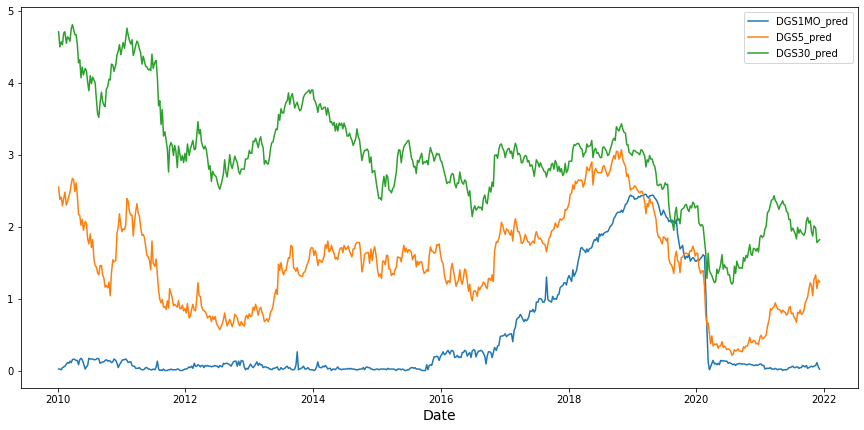

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(Y)
plt.xlabel('Date', size=14)
plt.legend(['DGS1MO_pred','DGS5_pred','DGS30_pred'])
plt.show()

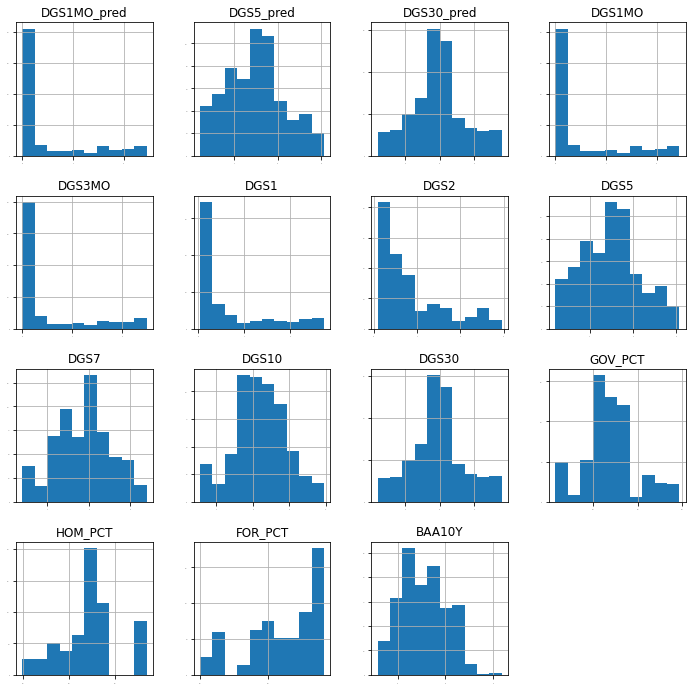

In [ ]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

NameError: ignored

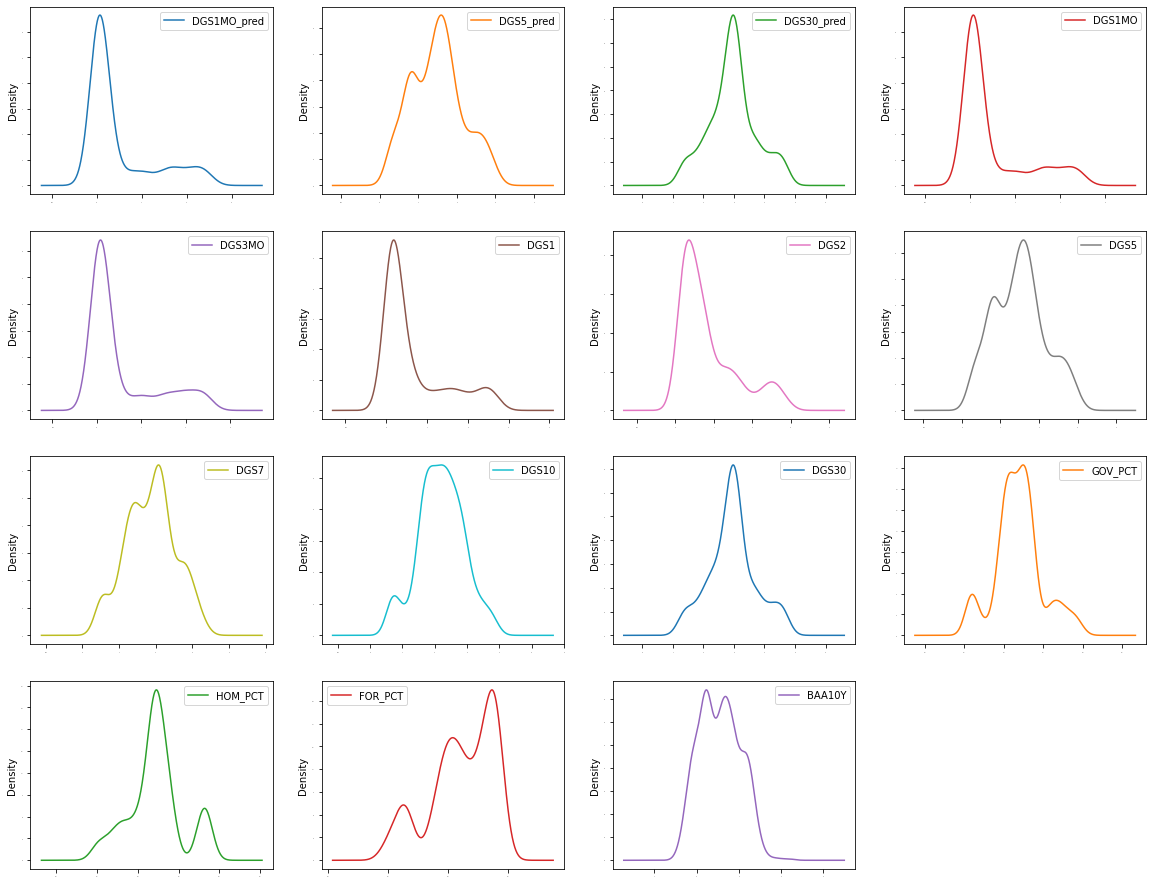

In [ ]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(20,20))
pyplot.show()

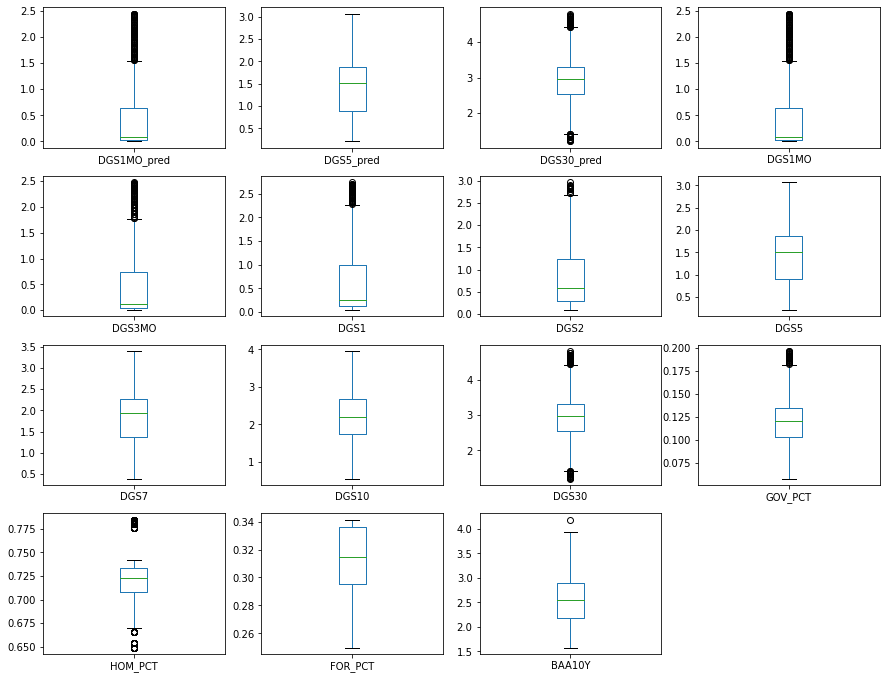

In [ ]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

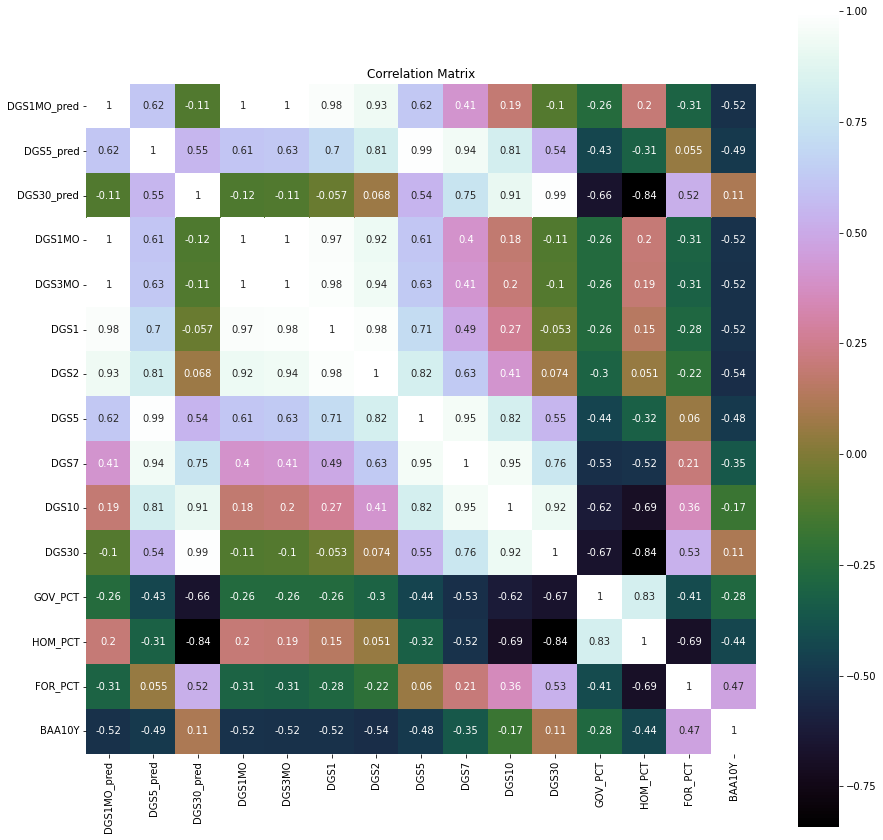

In [ ]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

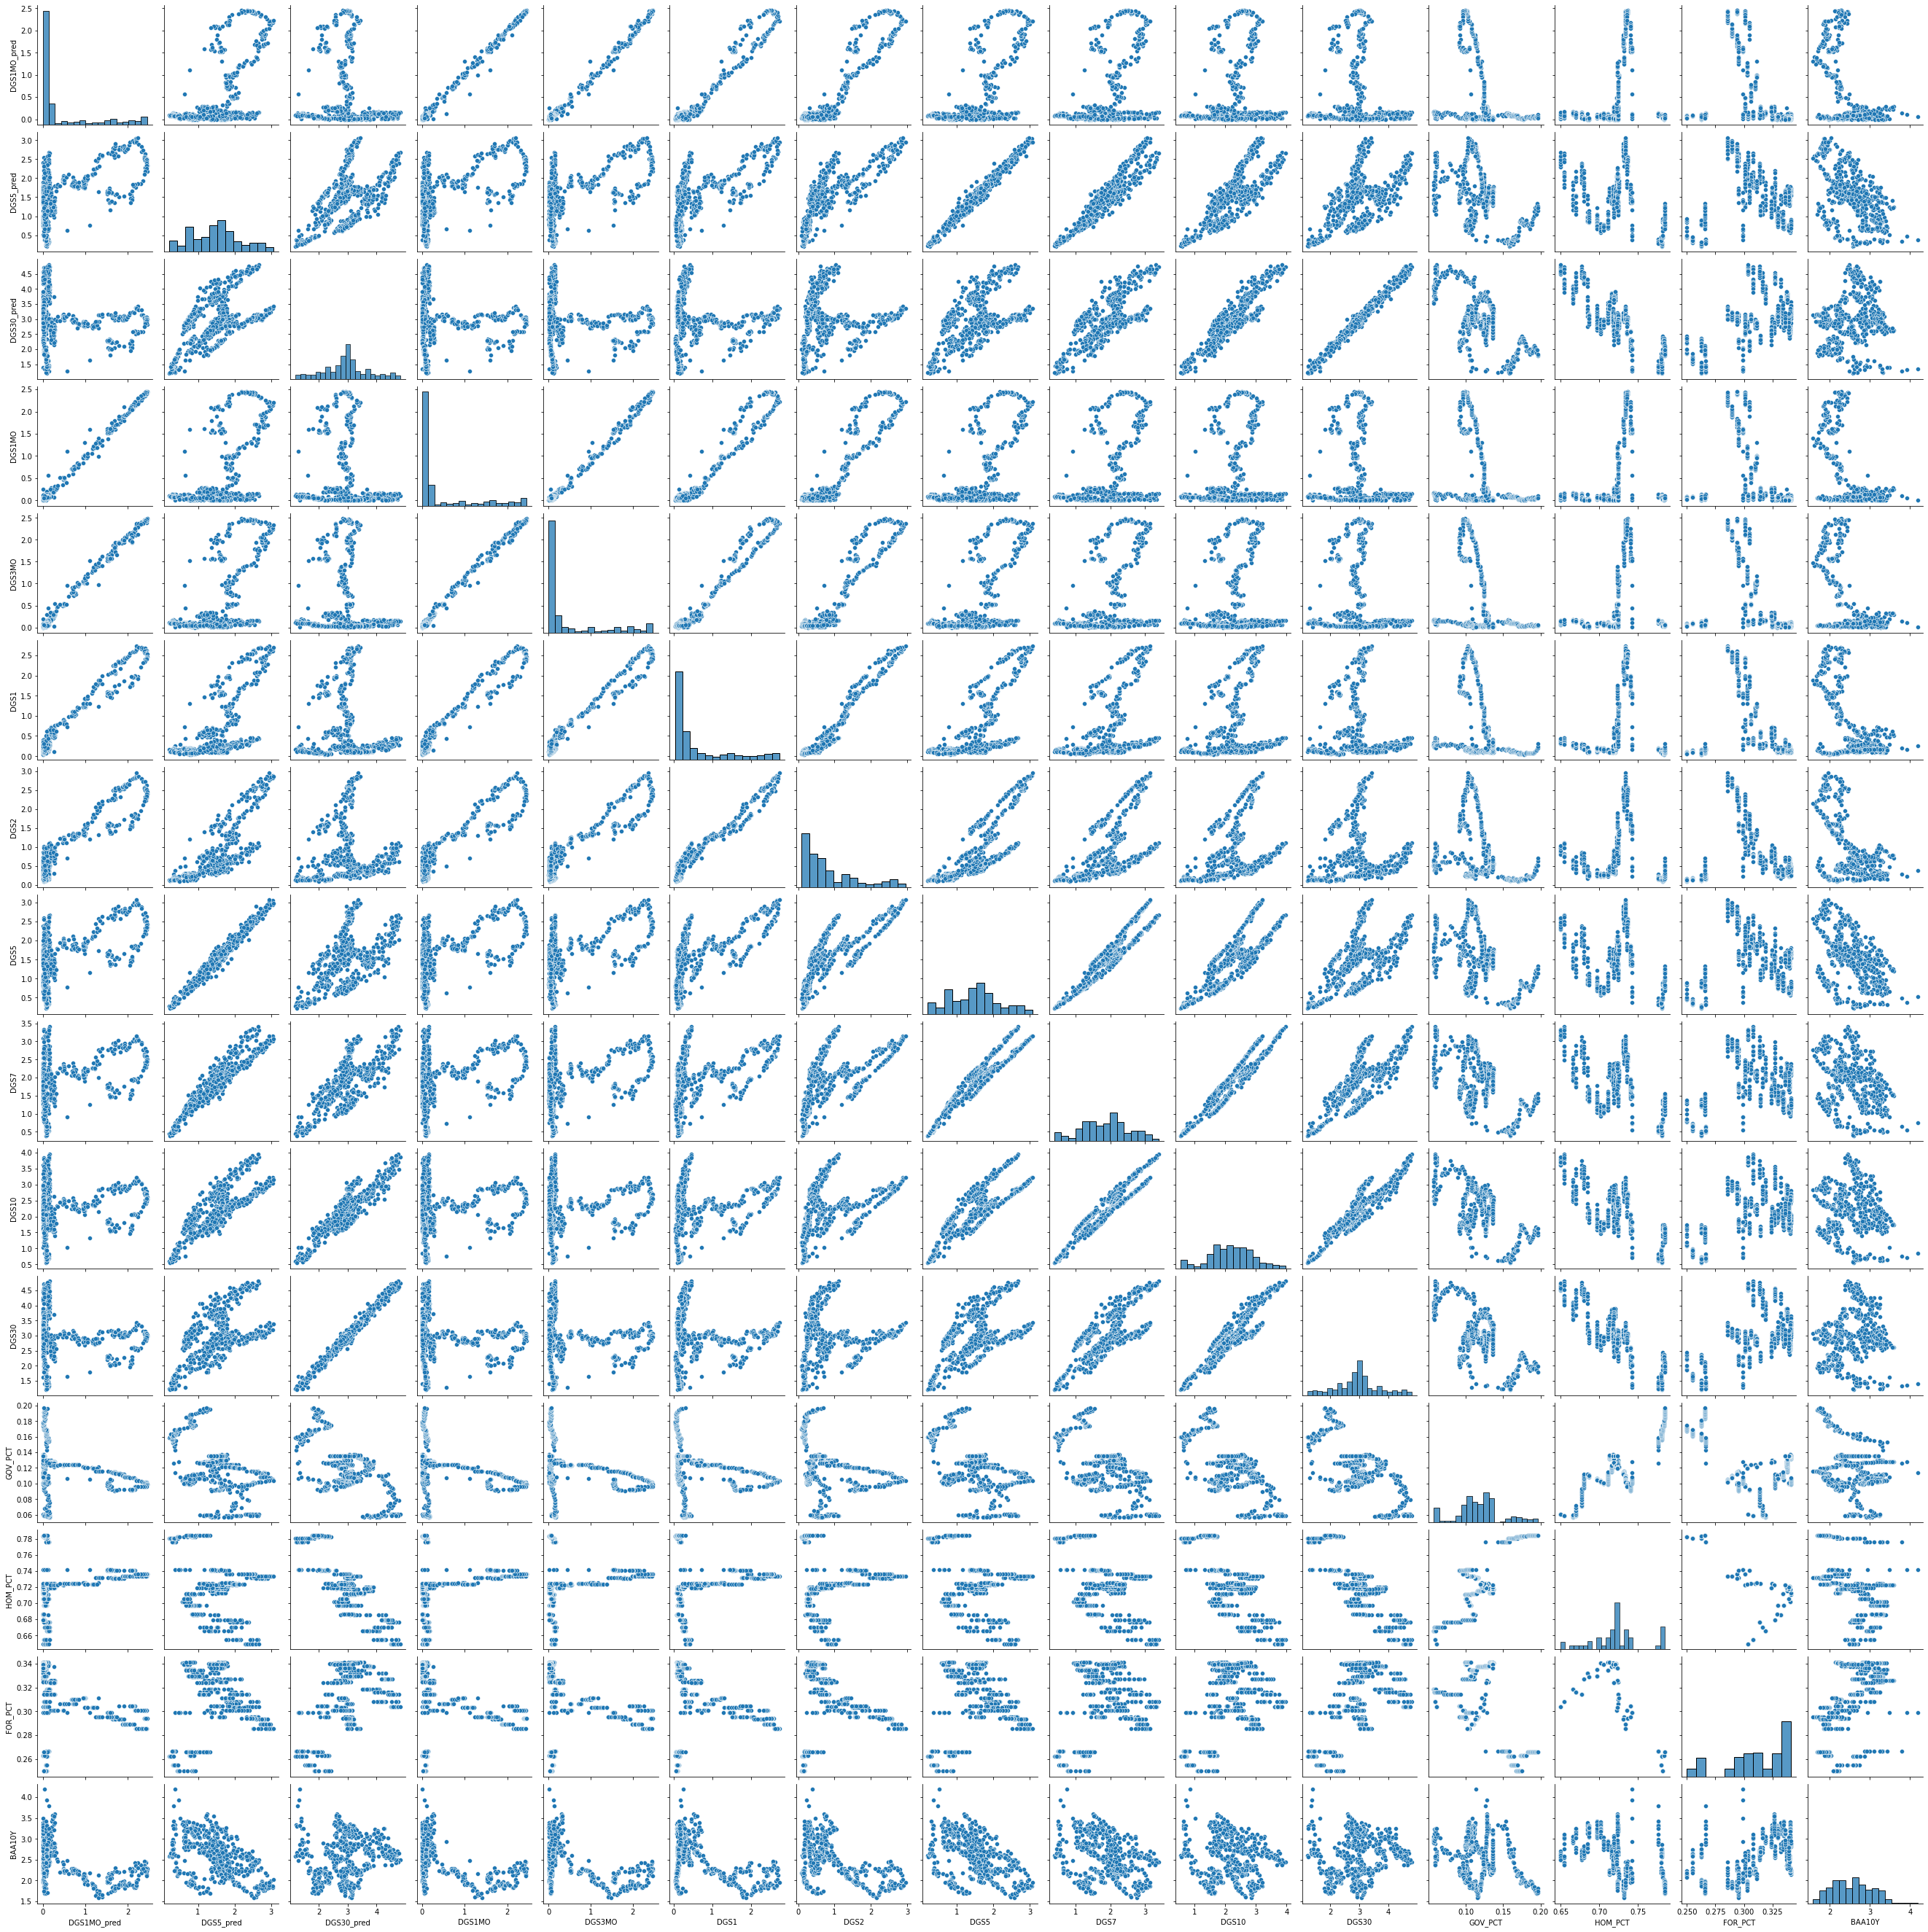

In [ ]:
# Scatterplot Matrix
sns.pairplot(dataset)


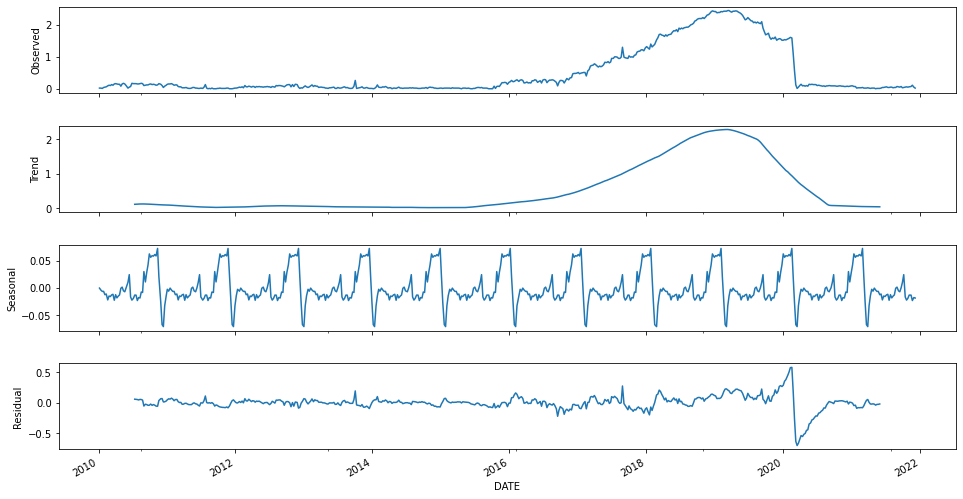

In [ ]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

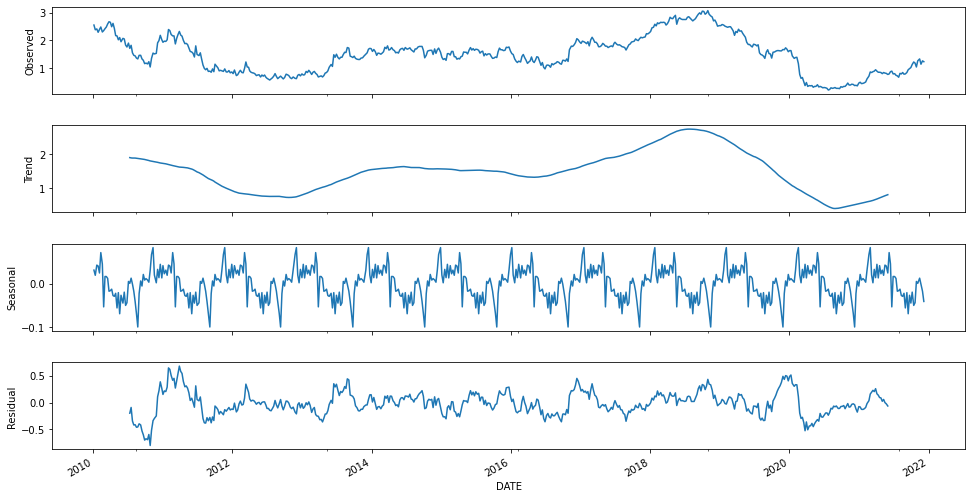

In [ ]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

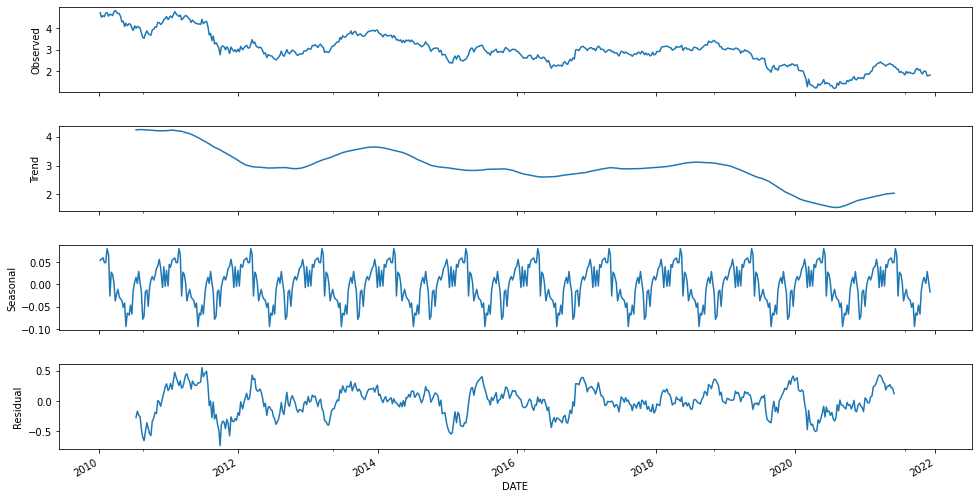

In [ ]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [ ]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)

for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
      Specs       Score
0    DGS1MO  111747.794
1    DGS3MO  102244.270
2      DGS1   12805.225
3      DGS2    3766.118
4      DGS5     378.082
11   BAA10Y     220.668
5      DGS7     118.717
10  FOR_PCT      62.771
8   GOV_PCT      42.822
9   HOM_PCT      24.502
--------------
DGS5_pred
      Specs      Score
4      DGS5  26487.356
5      DGS7   4854.926
3      DGS2   1186.550
6     DGS10   1176.532
2      DGS1    578.454
1    DGS3MO    386.423
0    DGS1MO    347.507
7     DGS30    251.607
11   BAA10Y    187.481
8   GOV_PCT    137.834
--------------
DGS30_pred
      Specs      Score
7     DGS30  32393.588
6     DGS10   2971.981
9   HOM_PCT   1410.676
5      DGS7    789.177
8   GOV_PCT    471.977
4      DGS5    248.420
10  FOR_PCT    227.525
0    DGS1MO      8.480
11   BAA10Y      7.866
1    DGS3MO      7.083
--------------


In [ ]:
validation_size = 0.2

#En caso de que los datos no dependan de la serie temporal, entonces el entrenamiento y la prueba se dividen aleatoriamente
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [ ]:
num_folds = 10
scoring = 'neg_mean_squared_error'

In [ ]:
# comprobar los algoritmos al azar
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [ ]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.008155760071629468 
Std CV Error: (0.0022917006319195326) 
Training Error:
DGS1MO_pred    0.003
DGS5_pred      0.010
DGS30_pred     0.011
dtype: float64 
Test Error:
DGS1MO_pred    0.001
DGS5_pred      0.009
DGS30_pred     0.009
dtype: float64
----------
LASSO: 
Average CV error: 0.5275303790818742 
Std CV Error: (0.07675594992620269) 
Training Error:
DGS1MO_pred    0.570
DGS5_pred      0.436
DGS30_pred     0.571
dtype: float64 
Test Error:
DGS1MO_pred    0.478
DGS5_pred      0.464
DGS30_pred     0.667
dtype: float64
----------
EN: 
Average CV error: 0.4695160990628272 
Std CV Error: (0.07514585822598827) 
Training Error:
DGS1MO_pred    0.458
DGS5_pred      0.436
DGS30_pred     0.501
dtype: float64 
Test Error:
DGS1MO_pred    0.384
DGS5_pred      0.464
DGS30_pred     0.586
dtype: float64
----------
KNN: 
Average CV error: 0.009929463888888887 
Std CV Error: (0.0034876407294728282) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.008
DGS30_pred     0.008
d

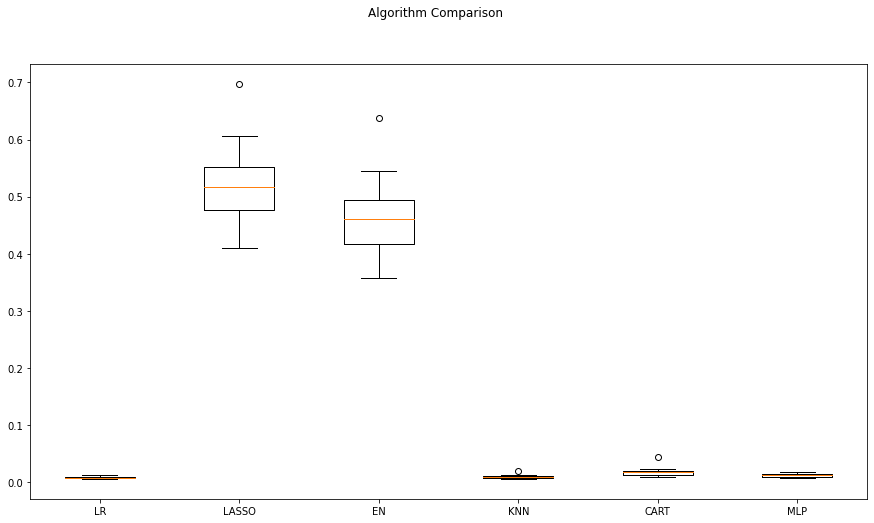

In [ ]:
# comparar algoritmos
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

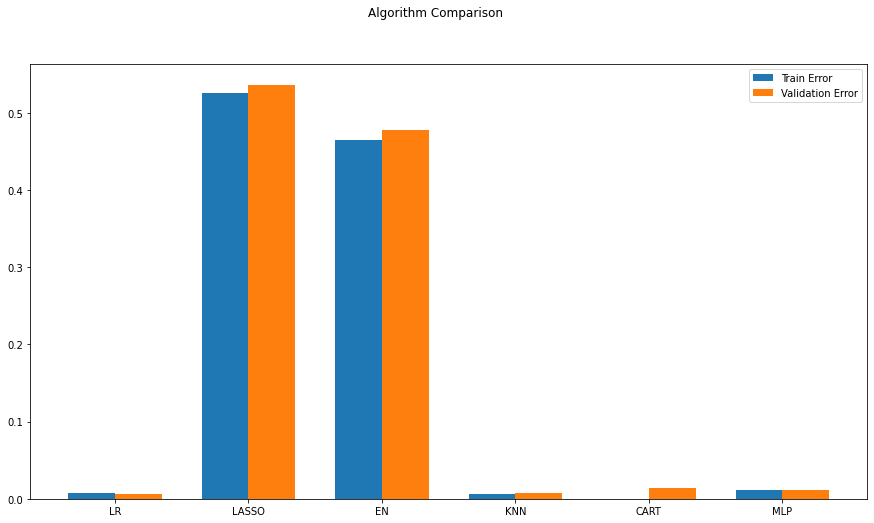

In [ ]:
# comparar algoritmos
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
plt.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tupla, longitud = n_capas - 2, por defecto (100,)
    El ith elemento representa el número de neuronas en el ith
    capa oculta.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Best: -0.014343 using {'hidden_layer_sizes': (20, 30, 20)}
-0.025657 (0.008642) with: {'hidden_layer_sizes': (20,)}
-0.016581 (0.007105) with: {'hidden_layer_sizes': (50,)}
-0.022845 (0.008300) with: {'hidden_layer_sizes': (20, 20)}
-0.014343 (0.004179) with: {'hidden_layer_sizes': (20, 30, 20)}


In [ ]:
# preparar el modelo
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [ ]:
# estimar la precisión en el conjunto de validación
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# preparar el modelo
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.006510, MSE MLP = 0.011670
R2 Regression = 0.987879, R2 MLP = 0.978524


In [ ]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

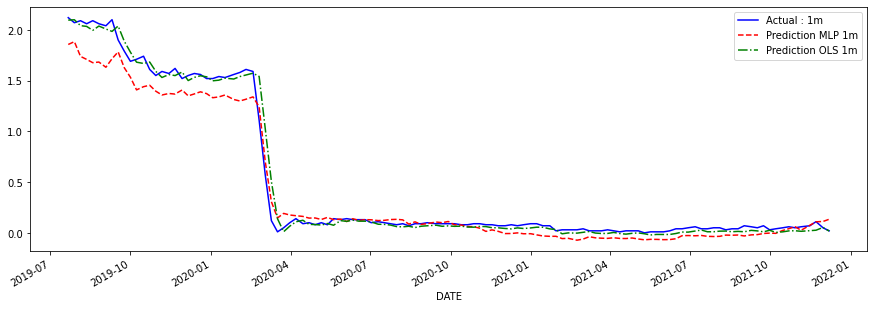

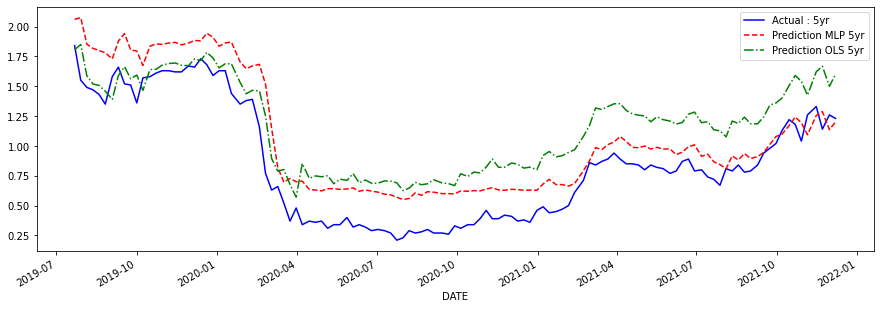

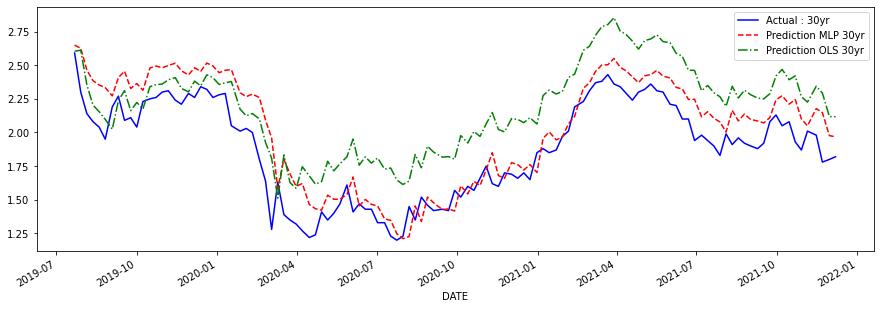

In [ ]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(15,5), style=['b-','r--','g-.'])

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(15,5), style=['b-','r--','g-.'])

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(15,5), style=['b-','r--','g-.'])

* En general, la regresión y el MLP son comparables; sin embargo, para el tenor de 1m, el ajuste con el MLP es ligeramente pobre en comparación con la regresión. Sin embargo, el aprendizaje multitarea con redes neuronales es más intuitivo para modelar muchas series temporales simultáneamente.

###**Conclucion**
El modelo de regresión lineal, a pesar de su sencillez, es una referencia difícil de superar para este tipo de previsiones de un paso adelante, dada la característica dominante del último valor disponible de la variable a predecir. Los resultados de la RNA en este caso práctico son comparables a los modelos de regresión lineal.

Lo bueno de la RNA es que es más flexible a las condiciones cambiantes del mercado. Además, los modelos de RNA pueden mejorarse realizando una búsqueda de cuadrícula en otros hiperparámetros y utilizando una red neuronal recurrente como la LSTM.